## The Dawid-Skene model with priors

The Dawid-Skene model (1979) is perhaps one of the first models to discover *true item states/effects from multiple noisy measurements*. Since then, there have been multiple models that improve over the basic model. This notebook covers the Dawid-Skene model which has been enhanced with priors.

The model follows implementation in Rebecca J. Passonneau, Bob Carpenter, “The Benefits of a Model of Annotation”, TACL, 2014.

In [2]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [5]:
data = np.load(pm.get_data('extrahard_MC_500_5_4.npz.npy'))
z_true = np.load(pm.get_data('extrahard_MC_500_5_4_reference_classes.npy'))

I = data.shape[0]               # number of items
J = data.shape[1]               # number of annotators
K = data.shape[2]               # number of classes
N = I * J


In [29]:
data.shape

(500, 5, 4)

In [36]:
# create data triplets
jj = list()  # annotator IDs
ii = list()  # item IDs
y = list()   # response

# initialize true category with majority votes
z_init = np.zeros( I, dtype=np.int64 )

# create data triplets
for i in range( I ):
    ks = list()
    for j in range( J ):
        dat = data[ i, j, : ]
        #print(dat)
        #[0. 0. 1. 0.]
        k = np.where( dat == 1 )[0][0]
        #print(k)
        #2
        ks.append( k )
        ii.append( i )
        jj.append( j )
        y.append( k )

    # getting maj vote for work item i (dealing with numpy casts)
    
    #print(ks)
    #[2, 0, 2, 2, 2]
    
    #print(np.bincount( np.array( ks ) ))
    #[1 0 4]
    
    #print(np.bincount( np.array( ks ) ).argmax()) 
    #2
    
    z_init[ i ] = np.bincount( np.array( ks ) ).argmax()

In [7]:
confMat = confusion_matrix( z_true, z_init )
print( "Majority vote estimate of true category:\n" , confMat )

Majority vote estimate of true category:
 [[120   2   1   2]
 [  5 116   4   0]
 [  4   6 113   2]
 [  4   3   3 115]]


In [38]:
# class prevalence (flat prior)
#The class prevalence prior tells the proportion of categories in the data. 
#Since we are completely ignorant about category proportions, 
#it is meaningful to set a flat distribution.
alpha = np.ones( K )
print(alpha)

# individual annotator confusion matrices - dominant diagonal
#We will initialize confusion matrices with uniform values with 
#slightly dominant diagonal – our annotators are expected to provide meaningful labels.
beta = np.ones( (K,K) ) + np.diag( np.ones(K) )
print(beta)

[1. 1. 1. 1.]
[[2. 1. 1. 1.]
 [1. 2. 1. 1.]
 [1. 1. 2. 1.]
 [1. 1. 1. 2.]]


### Defining the model:

First, we will need two random variables to encode class prevalence (pi) and annotator confusion matrices (theta). The two random variables can be naturally modeled with Dirichlet.

Second, we will define a variable for the true/hidden category for each work item. The Categorical distribution fits well our purpose to model a work item with K possible states.

Finally, a special variable for observed data brings together all random variables. This is the variable (Categorical) where the data is injected. The parametrization of the variable needs to be explained: the observation y[n] is generated according to Categorical distribution by worker y[n] for item ii[n], where the true label is z[ ii[n] ].



In [9]:
model = pm.Model()

with model:
    pi = pm.Dirichlet( 'pi', a=alpha, shape=K )
    theta = pm.Dirichlet( 'theta', a=beta, shape=(J,K,K) )
    z = pm.Categorical( 'z', p=pi, shape=I, testval=z_init )
    y_obs = pm.Categorical( 'y_obs', p=theta[ jj, z[ ii ] ], observed=y )

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


### Inference 
With model defined, we also need to set up the inference machinery. The variables of interest (pi, theta and z) will be divided in two groups: continuous (pi,theta) and discrete (z). The step methods are different: Metropolis or NUTS for former and CategoricalGibbsMetropolis for latter.

Note: Running the following block will perform inference for our variables of interest and store results in the trace variable. The trace variable will contain a wealth of information that will be useful to perfom diagnostics and get posteriors for our three hidden variables – class prevalence, annotator confusion matrices and true categories for all work items.

In [10]:
with model:
    step1 = pm.Metropolis( vars=[pi,theta] )
    step2 = pm.CategoricalGibbsMetropolis( vars=[z] )
    trace = pm.sample( 5000, step=[step1, step2], progressbar=True )


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [theta]
>>Metropolis: [pi]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/pyth

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13371e518>,
      dtype=object)

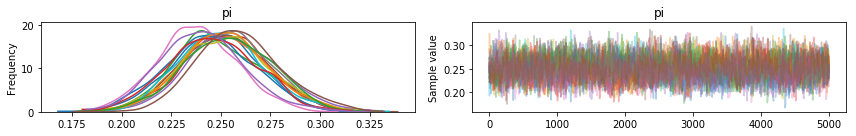

In [11]:
pm.traceplot( trace, varnames=['pi'] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133476898>,
      dtype=object)

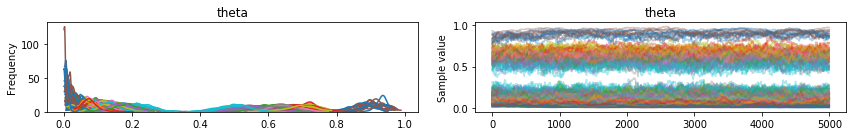

In [13]:
pm.traceplot( trace, varnames=['theta'] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1377705c0>,
      dtype=object)

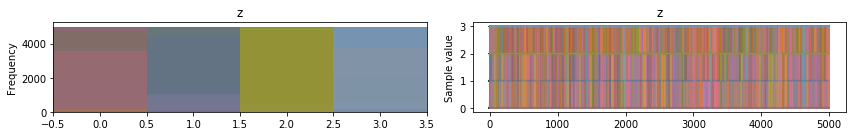

In [14]:
pm.traceplot( trace, varnames=['z'] )

In [17]:
#error:
#pm.traceplot( trace, varnames=['y_obs'] )

In [18]:
z = trace['z'][-1000:,:]

z_hat = np.zeros( I )
for i in range( I ):
    z_hat[ i ] = np.bincount( z[:,i] ).argmax()

In [19]:
confMat = confusion_matrix( z_true, z_hat )
print( "Dawid-Skene estimate of true category:\n", confMat )

Dawid-Skene estimate of true category:
 [[122   1   1   1]
 [  0 120   3   2]
 [  1   1 118   5]
 [  2   2   1 120]]


In [20]:
np.set_printoptions(precision=2)
for j in range( J ):
    print( "Annotator j=" + str(j) )
    Cj = trace['theta'][-1,j]
    print( Cj )

Annotator j=0
[[0.85 0.02 0.11 0.02]
 [0.01 0.94 0.02 0.03]
 [0.04 0.02 0.93 0.01]
 [0.04 0.02 0.02 0.93]]
Annotator j=1
[[0.66 0.1  0.1  0.14]
 [0.1  0.61 0.18 0.1 ]
 [0.09 0.2  0.57 0.14]
 [0.05 0.16 0.07 0.72]]
Annotator j=2
[[0.55 0.17 0.17 0.12]
 [0.1  0.51 0.2  0.19]
 [0.14 0.03 0.71 0.12]
 [0.14 0.09 0.15 0.63]]
Annotator j=3
[[0.6  0.11 0.18 0.11]
 [0.13 0.68 0.09 0.1 ]
 [0.06 0.06 0.78 0.09]
 [0.06 0.09 0.21 0.65]]
Annotator j=4
[[0.57 0.18 0.12 0.14]
 [0.18 0.5  0.23 0.09]
 [0.16 0.08 0.52 0.24]
 [0.26 0.14 0.07 0.52]]
